In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import confusion_matrix, log_loss, roc_auc_score, accuracy_score, make_scorer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from scipy.sparse import hstack

Построить линейную модель, которая хорошо произвордит ранжирование (может сказать, что один банер лучше/хуже на том или ином контексте)

### Анализ данных

In [6]:
data = pd.read_csv('data.csv')
data.head()

,date_time,zone_id,banner_id,oaid_hash,campaign_clicks,os_id,country_id,banner_id0,rate0,g0,coeff_sum0,banner_id1,rate1,g1,coeff_sum1,impressions,clicks
0,2021-09-27 00:01:30.000000,0,0,5664530014561852622,0,0,0,1240,0.067,0.035016,-7.268846,0,0.010,0.049516,-5.369901,1,1
1,2021-09-26 22:54:49.000000,1,1,5186611064559013950,0,0,1,1,0.002,0.054298,-2.657477,269,0.004,0.031942,-4.449220,1,1
2,2021-09-26 23:57:20.000000,2,2,2215519569292448030,3,0,0,2,0.014,0.014096,-3.824875,21,0.014,0.014906,-3.939309,1,1
3,2021-09-27 00:04:30.000000,3,3,6262169206735077204,0,1,1,3,0.012,0.015232,-3.461357,99,0.006,0.050671,-3.418403,1,1
4,2021-09-27 00:06:21.000000,4,4,4778985830203613115,0,1,0,4,0.019,0.051265,-4.009026,11464230,6.790,0.032005,-2.828797,1,1


In [3]:
def analysis(data: pd.DataFrame):
    """
    Проводит анализ данных, строит графики распределений и корреляций.
    """
    
    print('Количество логов:', data.shape[0])
    print('Количество переменных:', data.shape[1])
    print('----------------------------------------------------')
    
    data.info()
    print('----------------------------------------------------')
    
    # Посмотрим на дату
    data['date_time'] = pd.to_datetime(data['date_time'], format="%Y-%m-%d %H:%M:%S.%f")
    print('Значения, которые принимает дата')
    print('                                                    ')
    
    print(data['date_time'].dt.date.value_counts())
    # Уберем ненужные переменные
    data = data.drop(columns = ['oaid_hash', 'banner_id0', 'banner_id1', 'rate0', 'rate1', 'g0', 'g1', 'coeff_sum0', 'coeff_sum1'])
    print('----------------------------------------------------')
    
    # Проверяем наличие пропусков
    print('Количество пропусков по переменным')
    print('                                                    ')
    print(data.isnull().sum() / data.shape[0] * 100)
    print('----------------------------------------------------')
    
    print('Описательная статистика')
    print('                                                    ')
    print(data.describe().apply(lambda s: s.apply('{0:.3f}'.format)))
    print('----------------------------------------------------')
    
    print('Количество уникальных значений')
    print('                                                    ')
    print(data.nunique())
    print('----------------------------------------------------')
    # Графики по переменным
    
    ## Клики
    plt.hist(data.clicks)
    plt.ylabel('Количество')
    plt.title('Дисбаланс в кликах')
    plt.grid()
    plt.show()
    
    ## Страны
    plt.hist(data.country_id)
    plt.ylabel('Количество')
    plt.title('Страны')
    plt.grid()
    plt.show()
    
    ## Операционная система
    plt.hist(data.os_id)
    plt.ylabel('Количество')
    plt.title('Операционная система')
    plt.grid()
    plt.show()
    
    ## Зона
    plt.hist(data.zone_id)
    plt.ylabel('Количество')
    plt.title('Зона')
    plt.grid()
    plt.show()
    
    ## Количество показов данной кампании
    plt.hist(data.campaign_clicks)
    plt.ylabel('Количество')
    plt.title('Компания')
    plt.grid()
    plt.show()
    
    ## Баннер
    plt.hist(data.banner_id)
    plt.ylabel('Количество')
    plt.title('Баннер')
    plt.grid()
    plt.show()
    
    print('----------------------------------------------------')
    # Корреляция
    corr = data[['zone_id', 'banner_id', 'os_id', 'country_id', 'clicks','campaign_clicks']].corr()
    f, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(corr, ax=ax, annot=True,linewidths=3,cmap='Blues', fmt='.1g')
    plt.title("Корреляция фичей", y=1.05, size=15)

Количество логов: 15821472
Количество переменных: 17
----------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15821472 entries, 0 to 15821471
Data columns (total 17 columns):
 #   Column           Dtype  
---  ------           -----  
 0   date_time        object 
 1   zone_id          int64  
 2   banner_id        int64  
 3   oaid_hash        int64  
 4   campaign_clicks  int64  
 5   os_id            int64  
 6   country_id       int64  
 7   banner_id0       int64  
 8   rate0            float64
 9   g0               float64
 10  coeff_sum0       float64
 11  banner_id1       int64  
 12  rate1            float64
 13  g1               float64
 14  coeff_sum1       float64
 15  impressions      int64  
 16  clicks           int64  
dtypes: float64(6), int64(10), object(1)
memory usage: 2.0+ GB
----------------------------------------------------
Значения, которые принимает дата
                                                    
2021-09

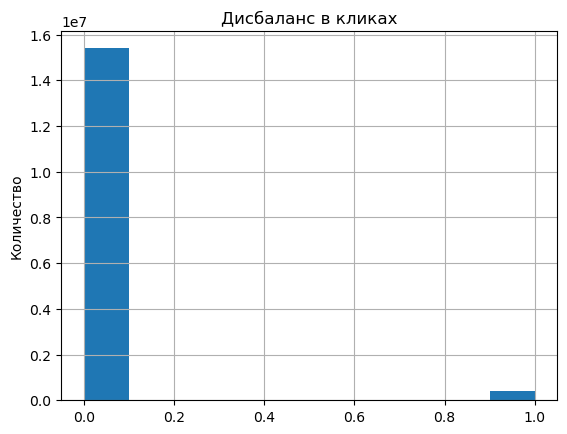

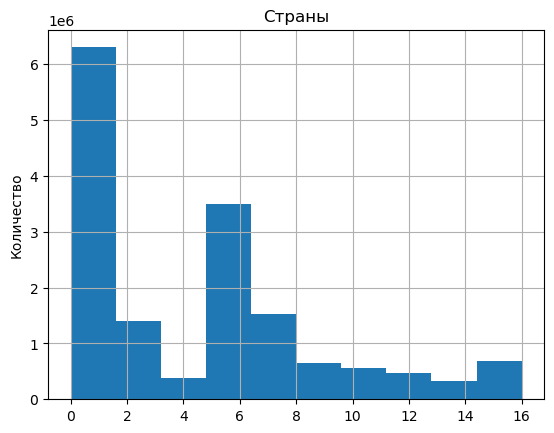

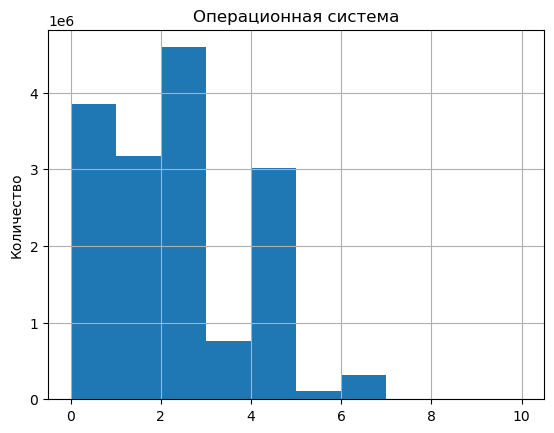

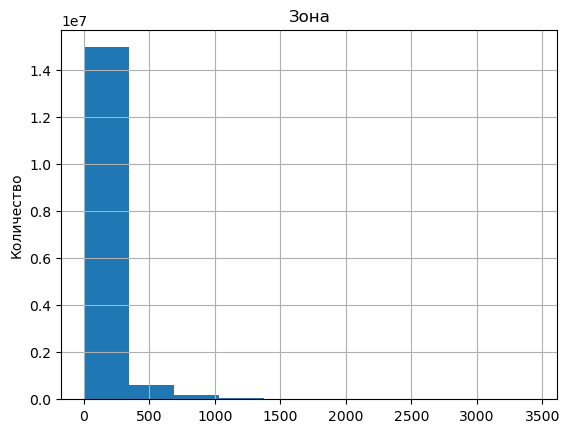

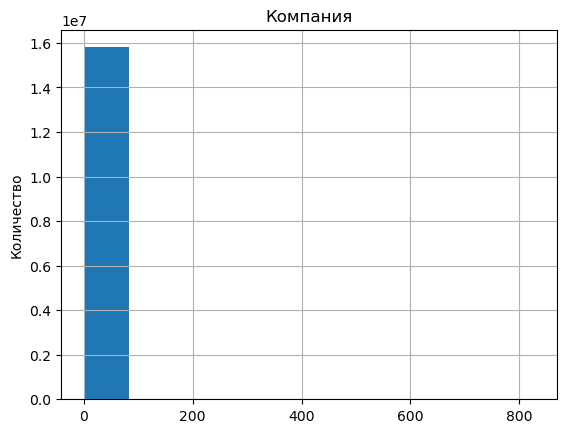

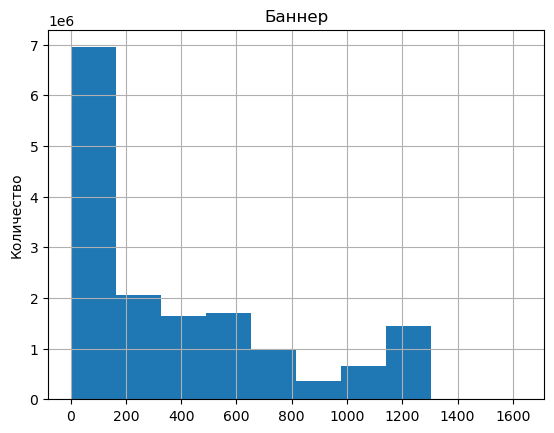

----------------------------------------------------


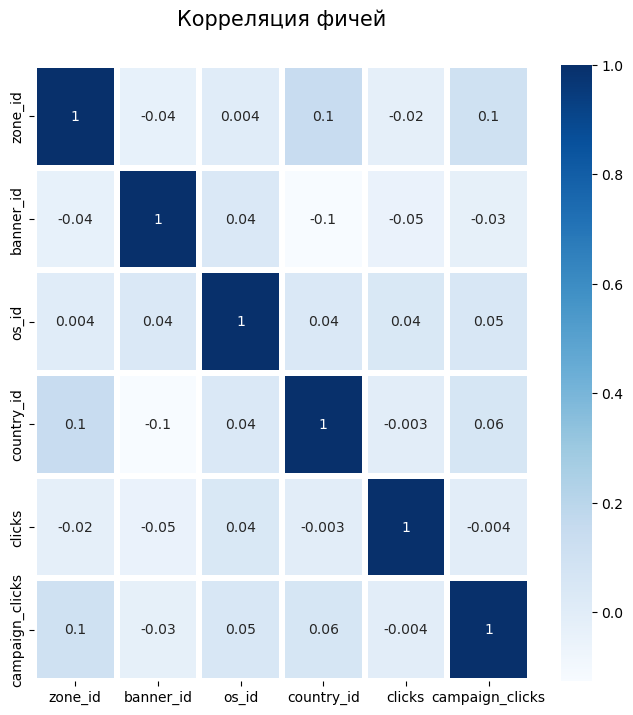

In [4]:
analysis(data)

Выводы:
* Переменная data_time показывает, что все данные взяты с одной недели с 09-26 по 10-01 (присутствует ошибка или выброс 09-01). В ходе генерации фичей из данной переменной можно взять день недели и час.
* У impressions все значения равны 1, она не пригодится.
* Пропусков в переменных нет.
* Между зависимыми переменными нет нигде высокой корреляции, что хорошо.

### Создание фичей и подготовка данных для модели

In [7]:
def train_test_split(data: pd.DataFrame):
    """
    Разбивает данные на тренировочную и тестовую выборки.
    В тестовую часть попадает последний день.
    """
    last_day = data['date_time'].dt.date.max()
    Test = data.loc[data['date_time'].dt.date == last_day]
    Train = data.loc[data['date_time'].dt.date < last_day]
    X_vars = [col for col in data.columns if col not in ['date_time', 'clicks']]
    X_train = Train.loc[:, X_vars]
    Y_train = Train.loc[:, 'clicks']
    X_test = Test.loc[:, X_vars]
    Y_test = Test.loc[:, 'clicks']
    return X_train, Y_train, X_test, Y_test

In [8]:
def feature_engineering(data: pd.DataFrame) -> pd.DataFrame:
    """
    Создает фичи и подготовливает категориальные и числовые признаки для подачи в модель.
    """
    
    # Выделим день недели и час в отдельные переменные
    data['date_time'] = pd.to_datetime(data['date_time'], format="%Y-%m-%d %H:%M:%S.%f")
    data['weekday'] = data['date_time'].dt.weekday
    data['hour'] = data['date_time'].dt.hour
    # Так как переменная hour циклична, трансформируем ее в 2 отдельные фичи
    data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
    data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)
    # Возьмем логарифм campaign_clicks, чтобы немного сгладить смещение
    data['log_campaign_clicks'] = np.log10(data['campaign_clicks'].to_numpy() + 1)
       
    # Удалим ненужные переменные    
    data = data.drop(columns = ['oaid_hash', 'banner_id0', 'banner_id1', 
                                'rate0', 'rate1', 'g0', 'g1', 'campaign_clicks',
                                'coeff_sum0', 'coeff_sum1', 'impressions', 'hour'])
    
    # Выделим train и test
    X_train, Y_train, X_test, Y_test = train_test_split(data) 
    
    numerical_features = ['log_campaign_clicks', 'hour_cos', 'hour_sin']
    
    categorical_features = ['zone_id', 'banner_id', 'os_id', 'country_id', 'weekday']
    encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=True, drop='first')
    x_categorical_train = encoder.fit_transform(X_train[categorical_features])
    x_categorical_test = encoder.transform(X_test[categorical_features])
  
    X_train = hstack((x_categorical_train, X_train[numerical_features]))
    X_test = hstack((x_categorical_test, X_test[numerical_features]))
    
    return X_train, Y_train, X_test, Y_test

In [9]:
X_train, Y_train, X_test, Y_test = feature_engineering(data)

C:\Users\PC\AppData\Roaming\Python\Python39\site-packages\sklearn\preprocessing\_encoders.py:228: UserWarning: Found unknown categories in columns [0, 1, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


### Моделирование

In [10]:
def create_model():
    """
    Создает модель логистической регрессии с L2-регуляризацией
    """
    return LogisticRegression(solver='liblinear', penalty='l2', random_state=42)

def cv(X_train, Y_train):
    """
    Выбирает наилучшую модель путем перебора параметра C
    """
    model = create_model()
    params = {'C': [0.001, 0.01, 0.1]}
    model_search = GridSearchCV(estimator=model, cv=3, param_grid=params, verbose=2,
                           scoring=["neg_log_loss", "roc_auc"], refit="neg_log_loss")
    model_search.fit(X_train, Y_train)
    best_model = model_search.best_estimator_
    print("Best params: {}".format(model_search.best_params_))
    return best_model.fit(X_train, Y_train)

In [11]:
model = cv(X_train, Y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END ............................................C=0.001; total time=  30.1s
[CV] END ............................................C=0.001; total time=  27.8s
[CV] END ............................................C=0.001; total time=  28.1s
[CV] END .............................................C=0.01; total time=  45.6s
[CV] END .............................................C=0.01; total time=  44.5s
[CV] END .............................................C=0.01; total time=  51.1s
[CV] END ..............................................C=0.1; total time= 1.5min
[CV] END ..............................................C=0.1; total time= 1.4min
[CV] END ..............................................C=0.1; total time= 1.5min
Best params: {'C': 0.1}


In [12]:
best_model_roc = round(roc_auc_score(Y_test, model.predict_proba(X_test)[:, 1]), 3)
best_model_loss = round(log_loss(Y_test, model.predict_proba(X_test)), 3)
print('Best model results')
print(f'ROC AUC: {best_model_roc}, Log-loss: {best_model_loss}')

Best model results
ROC AUC: 0.779, Log-loss: 0.135


In [13]:
# Делаем прогноз с помощью модели, предсказывающей среднее значение
dummy_classifier = np.full(Y_test.shape, np.mean(Y_test))
print('Baseline model results')
print(f'ROC AUC: {round(roc_auc_score(Y_test, dummy_classifier), 3)}, Log-loss: {round(log_loss(Y_test, dummy_classifier), 3)}')

Baseline model results
ROC AUC: 0.5, Log-loss: 0.153
